In [1]:
import pandas as panda
import numpy as np
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = panda.read_csv("labeled_data.csv")
data

,Unnamed: 0,count,angry,happy,neither,class,tweet
0,1,3,0,3,0,1,""" Keeks is a bitch she curves everyone "" lol I..."
1,2,3,0,3,0,1,""" Murda Gang bitch its Gang Land """
2,3,3,0,2,1,1,""" So hoes that smoke are losers ? "" yea ... go..."
3,4,3,0,3,0,1,""" bad bitches is the only thing that i like """
4,5,3,1,2,0,1,""" bitch get up off me """
...,...,...,...,...,...,...,...
24768,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24769,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24770,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24771,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24773 entries, 0 to 24772
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24773 non-null  int64 
 1   count       24773 non-null  int64 
 2   angry       24773 non-null  int64 
 3   happy       24773 non-null  int64 
 4   neither     24773 non-null  int64 
 5   class       24773 non-null  int64 
 6   tweet       24773 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


<AxesSubplot:>

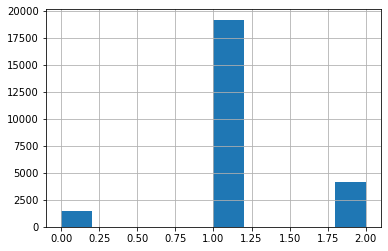

In [4]:
data['class'].hist()

In [5]:
tweet=data.tweet

In [6]:
def remove_space(tweet):  
    
    
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')    
    newtweet=tweet.str.replace(r'\s+', ' ')    
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')   
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    tweet_lower = newtweet.str.lower()
    
    return tweet_lower

In [7]:
tweets_space= remove_space(tweet)
data["tweets_w/o_space"]=tweets_space
data.head()

<ipython-input-6-5f5475067ae5>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=tweet.str.replace(r'\s+', ' ')
<ipython-input-6-5f5475067ae5>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
<ipython-input-6-5f5475067ae5>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')


,Unnamed: 0,count,angry,happy,neither,class,tweet,tweets_w/o_space
0,1,3,0,3,0,1,""" Keeks is a bitch she curves everyone "" lol I...",""" keeks is a bitch she curves everyone "" lol i..."
1,2,3,0,3,0,1,""" Murda Gang bitch its Gang Land """,""" murda gang bitch its gang land """
2,3,3,0,2,1,1,""" So hoes that smoke are losers ? "" yea ... go...",""" so hoes that smoke are losers ? "" yea ... go..."
3,4,3,0,3,0,1,""" bad bitches is the only thing that i like """,""" bad bitches is the only thing that i like """
4,5,3,1,2,0,1,""" bitch get up off me """,""" bitch get up off me """


In [8]:
def remove_urls(tweet):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', tweet)

data["tweet_w/o_url"] = data["tweets_w/o_space"].apply(lambda tweet: remove_urls(tweet))

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [10]:
from nltk.stem import WordNetLemmatizer

data['tweet_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]',' ',tweet)) for tweet in lis]) 
                     for lis in data['tweet_w/o_url']]

In [11]:
data["tokenized_tweet"] = data["tweet_lem"].apply(lambda x: x.split())

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [15]:
data["tweet_w/o_stop"] = data["tokenized_tweet"].apply(lambda x: [item for item in x if item not in stopwords])

In [16]:
processed_tweet = data["tweet_w/o_stop"].apply(lambda x: [stemmer.stem(i) for i in x]) 
    

In [17]:
 for i in range(len(processed_tweet)):
        processed_tweet[i] = ' '.join(processed_tweet[i])
        tweets_p= processed_tweet

In [18]:
data['processed_tweet'] = tweets_p

In [19]:
data.tweet

0        " Keeks is a bitch she curves everyone " lol I...
1                       " Murda Gang bitch its Gang Land "
2        " So hoes that smoke are losers ? " yea ... go...
3            " bad bitches is the only thing that i like "
4                                  " bitch get up off me "
                               ...                        
24768    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24769    you've gone and broke the wrong heart baby, an...
24770    young buck wanna eat!!.. dat nigguh like I ain...
24771                youu got wild bitches tellin you lies
24772    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24773, dtype: object

In [20]:
data.processed_tweet

0        keek bitch curv everyon lol walk convers like smh
1                               murda gang bitch gang land
2                                hoe smoke loser yea go ig
3                                     bad bitch thing like
4                                                bitch get
                               ...                        
24768    muthaf lie numbr lifeask numbr pearl corey ema...
24769      gone broke wrong heart babi drove redneck crazi
24770    young buck wanna eat dat nigguh like aint fuck...
24771                       youu got wild bitch tellin lie
24772    ruffl ntac eileen dahlia beauti color combin p...
Name: processed_tweet, Length: 24773, dtype: object

In [21]:
tweetstop = data['tweet_w/o_stop'] 

In [22]:
labels = data['class']

In [23]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

labels = encoder.fit_transform(np.array(labels).reshape(-1, 1))

In [24]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [25]:
data1 = []

for i in range(len(tweetstop)):
    data1.append(detokenize(tweetstop[i]))
print(data1[:5])

['keeks bitch curves everyone lol walked conversation like smh', 'murda gang bitch gang land', 'hoes smoke losers yea go ig', 'bad bitches thing like', 'bitch get']


In [26]:
data1 = np.array(data1)

In [27]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data1)
sequences = tokenizer.texts_to_sequences(data1)
tweets_in = pad_sequences(sequences, maxlen=max_len)
print(tweets_in)

[[   0    0    0 ... 1842    4  128]
 [   0    0    0 ...    2 1117 1843]
 [   0    0    0 ...  315   22  693]
 ...
 [   0    0    0 ...   96   95  246]
 [   0    0    0 ...    3 1826 1245]
 [   0    0    0 ...   94   17   48]]


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_in,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

18579 6194 18579 6194


In [29]:
model = Sequential()

model.add(layers.Embedding(max_words, 20))

model.add(layers.LSTM(15,dropout=0.5))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',
                             period=1,save_weights_only=False)

In [31]:
history1 = model.fit(X_train, y_train,steps_per_epoch=20,epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 21s 879ms/step - loss: 1.0409 - accuracy: 0.6901 - val_loss: 0.7739 - val_accuracy: 0.7706

Epoch 00001: val_accuracy improved from -inf to 0.77058, saving model to best_model.hdf5
Epoch 2/10
20/20 [==============================] - 14s 715ms/step - loss: 0.7090 - accuracy: 0.7721 - val_loss: 0.6424 - val_accuracy: 0.7706

Epoch 00002: val_accuracy did not improve from 0.77058
Epoch 3/10
20/20 [==============================] - 15s 750ms/step - loss: 0.6220 - accuracy: 0.7764 - val_loss: 0.5982 - val_accuracy: 0.7706

Epoch 00003: val_accuracy did not improve from 0.77058
Epoch 4/10
20/20 [==============================] - 14s 730ms/step - loss: 0.5606 - accuracy: 0.7765 - val_loss: 0.5049 - val_accuracy: 0.7838

Epoch 00004: val_accuracy improved from 0.77058 to 0.78382, saving model to best_model.hdf5
Epoch 5/10
20/20 [==============================] - 16s 832ms/step - loss: 0.4502 - accuracy: 0.8270 - val_loss: 0.4142 - val_accurac

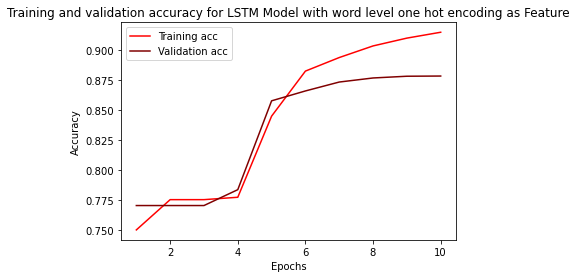

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

epochs = range(1, 11)

plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'maroon', label='Validation acc')
plt.title('Training and validation accuracy for LSTM Model with word level one hot encoding as Feature')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.show()

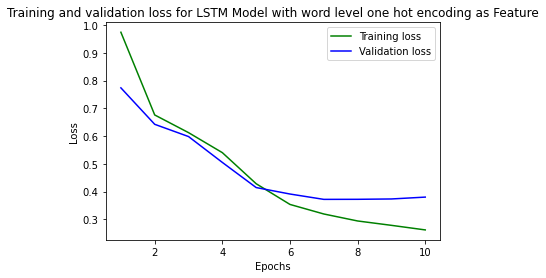

In [61]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, 11)

plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for LSTM Model with word level one hot encoding as Feature')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(data['processed_tweet'] ).toarray()
tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
tfidf.shape

(24773, 1000)

In [36]:
from sklearn.model_selection import train_test_split
X = tfidf
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, labels, random_state=42, test_size=0.2)

In [37]:
history2 = model.fit(X_train1, y_train1, steps_per_epoch=20, epochs=10,  validation_data=(X_test1, y_test1),
                     callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 142s 7s/step - loss: 0.7280 - accuracy: 0.7691 - val_loss: 0.6738 - val_accuracy: 0.7709

Epoch 00001: val_accuracy did not improve from 0.87859
Epoch 2/10
20/20 [==============================] - 156s 8s/step - loss: 0.6707 - accuracy: 0.7751 - val_loss: 0.6712 - val_accuracy: 0.7709

Epoch 00002: val_accuracy did not improve from 0.87859
Epoch 3/10
20/20 [==============================] - 175s 9s/step - loss: 0.6659 - accuracy: 0.7751 - val_loss: 0.6717 - val_accuracy: 0.7709

Epoch 00003: val_accuracy did not improve from 0.87859
Epoch 4/10
20/20 [==============================] - 189s 9s/step - loss: 0.6650 - accuracy: 0.7751 - val_loss: 0.6703 - val_accuracy: 0.7709

Epoch 00004: val_accuracy did not improve from 0.87859
Epoch 5/10
20/20 [==============================] - 192s 10s/step - loss: 0.6641 - accuracy: 0.7751 - val_loss: 0.6704 - val_accuracy: 0.7709

Epoch 00005: val_accuracy did not improve from 0.87859
Epoch 6/10
20/

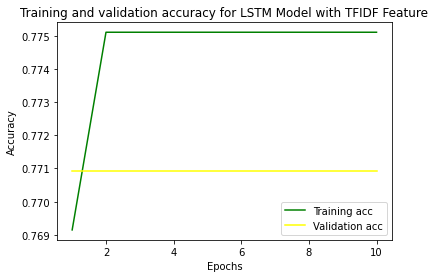

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, 11)

plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'yellow', label='Validation acc')
plt.title('Training and validation accuracy for LSTM Model with TFIDF Feature')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.show()

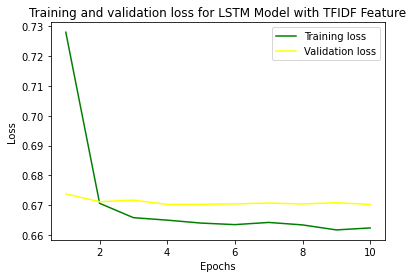

In [39]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, 11)

plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'yellow', label='Validation loss')
plt.title('Training and validation loss for LSTM Model with TFIDF Feature')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
bow_vectorizer = CountVectorizer( max_features=100, stop_words='english', ngram_range=(2,2))
bagofwords=bow_vectorizer.fit_transform(data['processed_tweet'] ).toarray()
bagofwords

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
bagofwords.shape

(24773, 100)

In [42]:
X = bagofwords
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, labels, random_state=42, test_size=0.2)

In [43]:
history3 = model.fit(X_train2, y_train2, epochs=10, steps_per_epoch=20, validation_data=(X_test2, y_test2),
                     callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 8s 304ms/step - loss: 0.6622 - accuracy: 0.7751 - val_loss: 0.6710 - val_accuracy: 0.7709

Epoch 00001: val_accuracy did not improve from 0.87859
Epoch 2/10
20/20 [==============================] - 6s 283ms/step - loss: 0.6614 - accuracy: 0.7751 - val_loss: 0.6714 - val_accuracy: 0.7709

Epoch 00002: val_accuracy did not improve from 0.87859
Epoch 3/10
20/20 [==============================] - 6s 284ms/step - loss: 0.6618 - accuracy: 0.7751 - val_loss: 0.6711 - val_accuracy: 0.7709

Epoch 00003: val_accuracy did not improve from 0.87859
Epoch 4/10
20/20 [==============================] - 5s 273ms/step - loss: 0.6615 - accuracy: 0.7751 - val_loss: 0.6706 - val_accuracy: 0.7709

Epoch 00004: val_accuracy did not improve from 0.87859
Epoch 5/10
20/20 [==============================] - 5s 267ms/step - loss: 0.6614 - accuracy: 0.7751 - val_loss: 0.6703 - val_accuracy: 0.7709

Epoch 00005: val_accuracy did not improve from 0.87859
Epoch 6/10

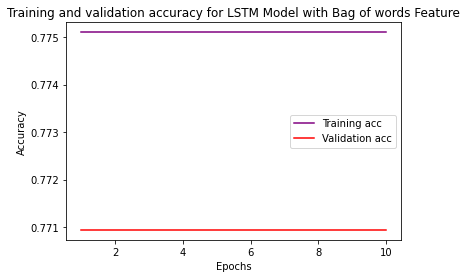

<Figure size 432x288 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, 11)

plt.plot(epochs, acc, 'purple', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy for LSTM Model with Bag of words Feature')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.show()

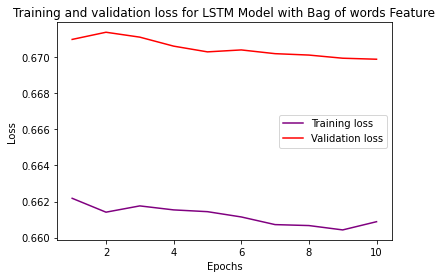

In [45]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, 11)

plt.plot(epochs, loss, 'purple', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss for LSTM Model with Bag of words Feature')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
modelling_features = np.concatenate([tfidf,bagofwords,tweets_in],axis=1)
modelling_features.shape

(24773, 1300)

In [47]:
X = modelling_features
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, labels, random_state=42, test_size=0.2)

In [48]:
history4= model.fit(X_train3, y_train3, epochs=10, steps_per_epoch=20, validation_data=(X_test3, y_test3),
                    callbacks=[checkpoint])

Epoch 1/10
20/20 [==============================] - 190s 9s/step - loss: 0.3447 - accuracy: 0.8890 - val_loss: 0.2964 - val_accuracy: 0.9051

Epoch 00001: val_accuracy improved from 0.87859 to 0.90515, saving model to best_model.hdf5
Epoch 2/10
20/20 [==============================] - 197s 10s/step - loss: 0.2767 - accuracy: 0.9101 - val_loss: 0.2820 - val_accuracy: 0.9041

Epoch 00002: val_accuracy did not improve from 0.90515
Epoch 3/10
20/20 [==============================] - 207s 10s/step - loss: 0.2508 - accuracy: 0.9174 - val_loss: 0.2809 - val_accuracy: 0.9025

Epoch 00003: val_accuracy did not improve from 0.90515
Epoch 4/10
20/20 [==============================] - 218s 11s/step - loss: 0.2334 - accuracy: 0.9225 - val_loss: 0.2797 - val_accuracy: 0.9041

Epoch 00004: val_accuracy did not improve from 0.90515
Epoch 5/10
20/20 [==============================] - 204s 10s/step - loss: 0.2141 - accuracy: 0.9257 - val_loss: 0.2810 - val_accuracy: 0.9043

Epoch 00005: val_accuracy did

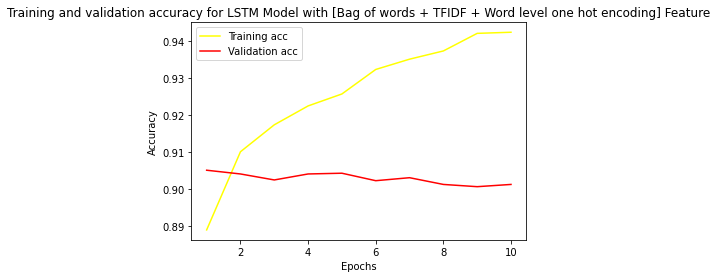

<Figure size 432x288 with 0 Axes>

In [49]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

epochs = range(1, 11)

plt.plot(epochs, acc, 'yellow', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy for LSTM Model with [Bag of words + TFIDF + Word level one hot encoding] Feature')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.show()

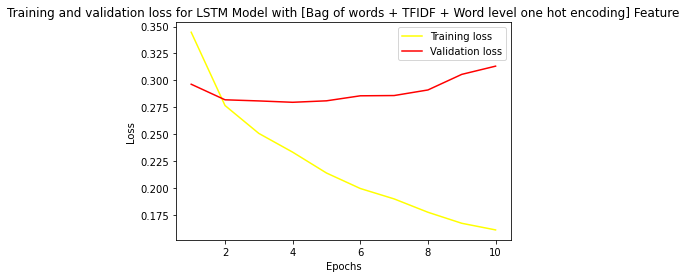

In [50]:
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, 11)

plt.plot(epochs, loss, 'yellow', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss for LSTM Model with [Bag of words + TFIDF + Word level one hot encoding] Feature')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2160      
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               8192      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 111,891
Trainable params: 111,891
Non-trainable params: 0
__________________________________________________